In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

In [2]:
path = r"C:\Users\Yijia Wang\Desktop\Open-House-Analysis\Data\July_2025\raw_data\DB_for MR Performance Analysis - CORE.MR.csv"
df = pd.read_csv(path)
# print("column names：")
# for col in df.columns:
#     print(f"- {col}")

In [3]:
# Only keep finished projects
df = df[df['Status'] == 'Finished'].copy()

In [4]:
# === Step 2: clean column names to remove extra spaces ===
df.columns = df.columns.str.strip().str.replace(':', '').str.replace('*', '').str.replace(' ', '_')

In [5]:
df = df.rename(columns={'Project_Manager': 'FS'})  


In [6]:
# === Step 3: clean date ===
date_fields = [
    'Make_Ready_Created_Date', 'Projected_Start_Date', 
    'Actual_Construction_Start_Date', 'Projected_Completion_Date', 
    'Actual_Confirm_Construction_Completion', 'Move_in_date'
]

for col in date_fields:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [7]:
# === Step 4: feature creation:add KPI columns ===
df['Month'] = df['Make_Ready_Created_Date'].dt.to_period('M')
df['Start_Delay'] = (df['Actual_Construction_Start_Date'] - df['Projected_Start_Date']).dt.days
df['Completion_Delay'] = (df['Actual_Confirm_Construction_Completion'] - df['Projected_Completion_Date']).dt.days
df['ACCC_to_Movein'] = (df['Move_in_date'] - df['Actual_Confirm_Construction_Completion']).dt.days

In [8]:
# === Step 5: make it to a long table ===
df_long = df.melt(
    id_vars=[
        'QRSerial', 'Month',
        'Start_Delay', 'Completion_Delay', 'ACCC_to_Movein',
        'MO_to_Create_MR', 'PCD_to_ACSD', 'PCD_to_ACCC',
        'Total_Actual_Budget_Cost', 'Status'
    ],
    value_vars=['PC', 'FM', 'CM', 'FS'],
    var_name='Role', value_name='Person'
)

In [9]:
# if name is missing, drop the row
df_long = df_long.dropna(subset=['Person'])

In [10]:
# === Step 6: summarize everyone's performance by month ===
performance = df_long.groupby(['Month', 'Role', 'Person']).agg({
    'QRSerial': 'count',
    'Start_Delay': 'mean',
    'Completion_Delay': 'mean',
    'ACCC_to_Movein': 'mean',
    'MO_to_Create_MR': 'mean',
    'PCD_to_ACSD': 'mean',
    'PCD_to_ACCC': 'mean',
    'Total_Actual_Budget_Cost': 'mean'
}).rename(columns={
    'QRSerial': 'Project_Count',
    'Start_Delay': 'Avg_Start_Delay',
    'Completion_Delay': 'Avg_Completion_Delay',
    'ACCC_to_Movein': 'Avg_ACCC_to_Movein',
    'MO_to_Create_MR': 'Avg_MO_to_MR',
    'PCD_to_ACSD': 'Avg_PCD_to_ACSD',
    'PCD_to_ACCC': 'Avg_PCD_to_ACCC',
    'Total_Actual_Budget_Cost': 'Avg_Budget'
}).reset_index()

In [11]:
# === Step 7 Pre: deal with missing before modeling ===
score_features = [
    'Avg_Start_Delay',
    'Avg_Completion_Delay',
    'Avg_ACCC_to_Movein',
    'Avg_MO_to_MR',
    'Avg_PCD_to_ACSD',
    'Avg_PCD_to_ACCC',
    'Avg_Budget',
]

# check count of missing values and calculate missing rate
missing_summary = performance[score_features].isna().sum().to_frame(name='Missing Count')
missing_summary['Total Count'] = len(performance)
missing_summary['Missing Rate (%)'] = (missing_summary['Missing Count'] / missing_summary['Total Count']) * 100

# rank with missing rate
missing_summary = missing_summary.sort_values(by='Missing Rate (%)', ascending=False)

print(missing_summary)

                      Missing Count  Total Count  Missing Rate (%)
Avg_ACCC_to_Movein              284         1627         17.455439
Avg_MO_to_MR                     39         1627          2.397050
Avg_Completion_Delay             33         1627          2.028273
Avg_PCD_to_ACCC                  33         1627          2.028273
Avg_PCD_to_ACSD                  18         1627          1.106331
Avg_Start_Delay                   9         1627          0.553165
Avg_Budget                        0         1627          0.000000


In [14]:
# delete any rows with missing values in score features
performance = performance.dropna(subset=score_features).copy()

In [ ]:
# Let's check again
missing_summary = performance[score_features].isna().sum().to_frame(name='Missing Count')
missing_summary['Total Count'] = len(performance)
missing_summary['Missing Rate (%)'] = (missing_summary['Missing Count'] / missing_summary['Total Count']) * 100
missing_summary = missing_summary.sort_values(by='Missing Rate (%)', ascending=False)
print(missing_summary)

                      Missing Count  Total Count  Missing Rate (%)
Avg_Start_Delay                   0         1341               0.0
Avg_Completion_Delay              0         1341               0.0
Avg_ACCC_to_Movein                0         1341               0.0
Avg_MO_to_MR                      0         1341               0.0
Avg_PCD_to_ACSD                   0         1341               0.0
Avg_PCD_to_ACCC                   0         1341               0.0
Avg_Budget                        0         1341               0.0


In [17]:
# === Step 7: detect abnormal behavior ===
features = performance[score_features]

model = IsolationForest(contamination=0.1, random_state=42)
performance['Anomaly_Score'] = model.fit_predict(features)
performance['Needs_Improvement'] = performance['Anomaly_Score'] == -1

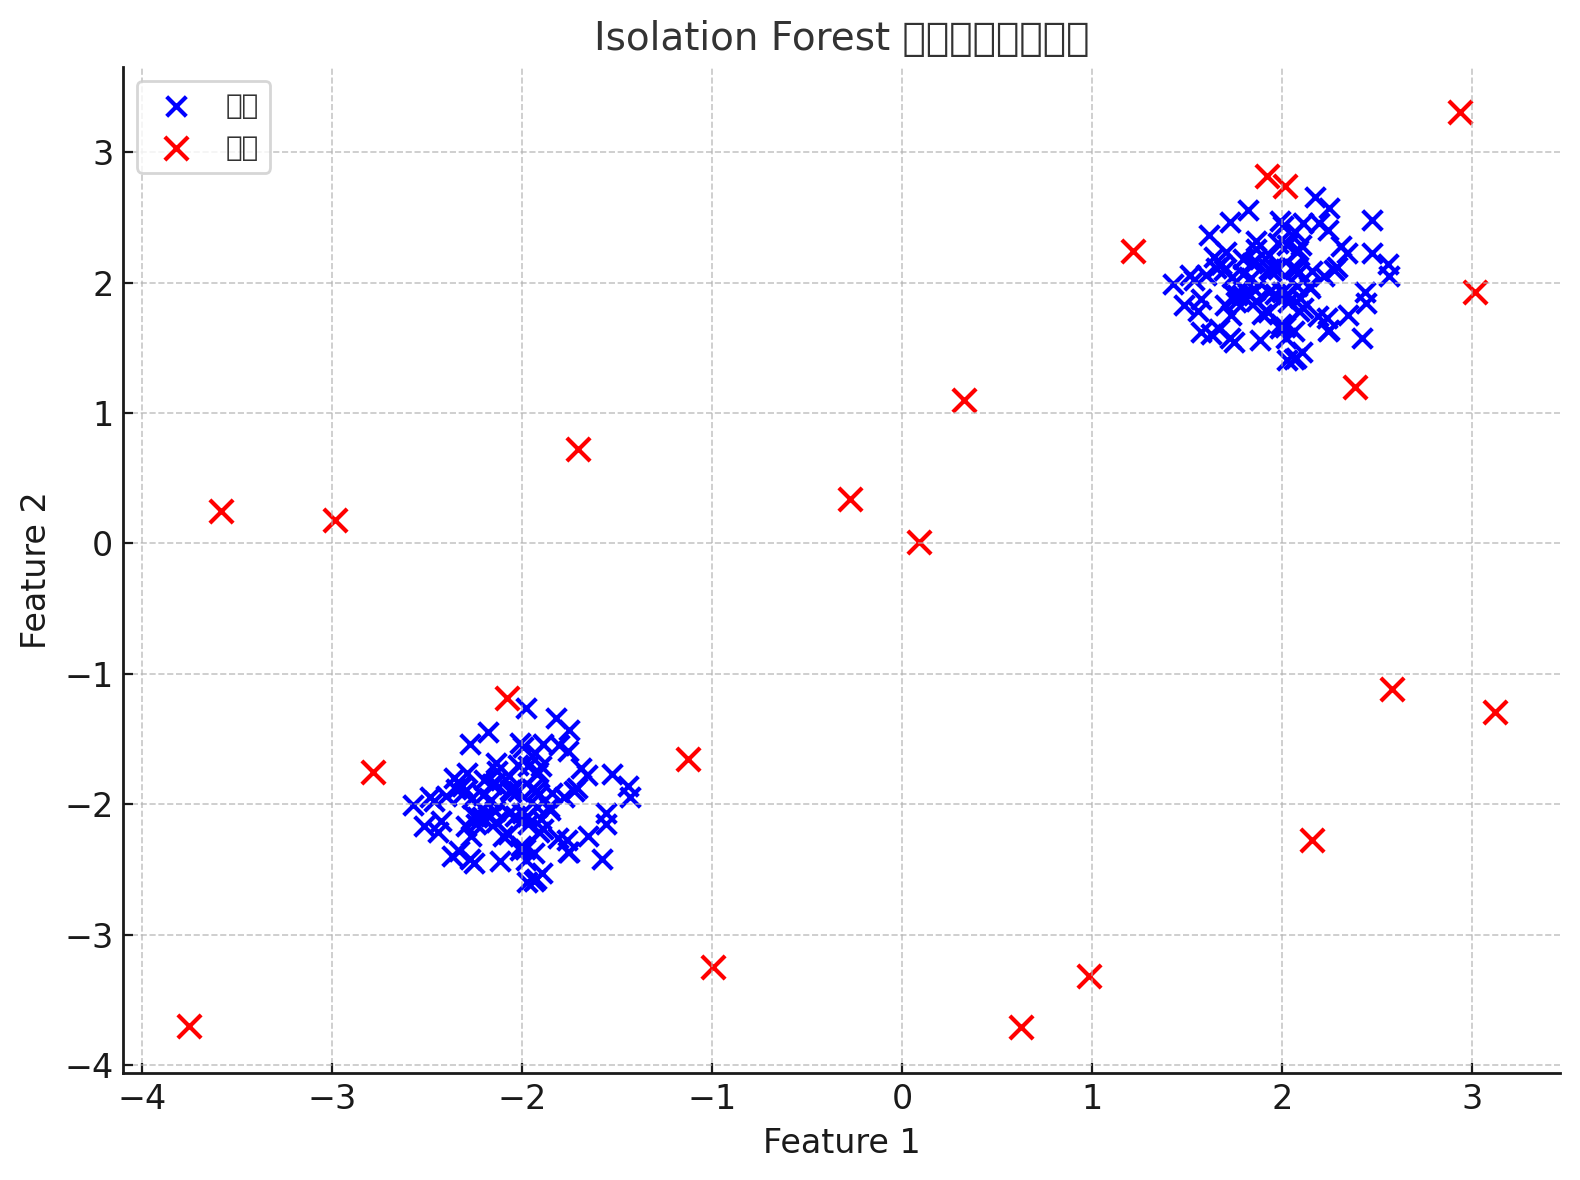

In [ ]:
# let's check the results
# Top abnormal performance with high budget
performance[performance['Needs_Improvement']].sort_values(
    by='Avg_Budget', ascending=False
).head(10)

,Month,Role,Person,Project_Count,Avg_Start_Delay,Avg_Completion_Delay,Avg_ACCC_to_Movein,Avg_MO_to_MR,Avg_PCD_to_ACSD,Avg_PCD_to_ACCC,Avg_Budget,Anomaly_Score,Needs_Improvement
394,2022-11,FS,Chad Lane,1,44.0,175.0,39.0,0.0,215.0,175.0,117584.59,-1,True
475,2023-02,FS,Brandon Kussy,1,7.0,58.0,21.0,0.0,91.0,58.0,98312.82,-1,True
765,2023-10,FS,Arturo Huerta Angel Rosas,1,10.0,43.0,70.0,0.0,96.0,43.0,92447.75,-1,True
602,2023-06,FS,Angel Rosas,1,14.0,80.0,62.0,0.0,118.0,80.0,91047.36,-1,True
600,2023-06,FM,Madaid Obeso,1,14.0,80.0,62.0,0.0,118.0,80.0,91047.36,-1,True
137,2021-12,FS,Cecil Brown,1,5.0,-85.0,35.0,0.0,335.0,-85.0,88155.44,-1,True
1122,2024-06,FS,Shaamar Moore,1,41.0,38.0,49.0,0.0,78.0,38.0,87093.98,-1,True
1095,2024-06,FM,Jamal Morris,1,41.0,38.0,49.0,0.0,78.0,38.0,87093.98,-1,True
177,2022-03,FS,Cecil Brown,1,12.0,179.0,27.0,0.0,230.0,179.0,86990.30,-1,True
259,2022-07,FS,Bryant Johnson,1,3.0,141.0,84.0,0.0,165.0,141.0,83535.23,-1,True


In [ ]:
# Top abnormal performance with high project count
performance[performance['Needs_Improvement']].sort_values(
    by='Project_Count', ascending=False
)

,Month,Role,Person,Project_Count,Avg_Start_Delay,Avg_Completion_Delay,Avg_ACCC_to_Movein,Avg_MO_to_MR,Avg_PCD_to_ACSD,Avg_PCD_to_ACCC,Avg_Budget,Anomaly_Score,Needs_Improvement
968,2024-03,FM,Ronald Brinson,17,39.866667,76.866667,79.545455,1.941176,97.733333,76.866667,30143.863529,-1,True
1001,2024-03,PC,Tom Blue,15,37.000000,48.000000,84.750000,2.800000,65.666667,48.000000,21739.115333,-1,True
843,2023-12,FM,Ronald Brinson,13,21.692308,83.230769,98.857143,0.307692,122.153846,83.230769,26892.713846,-1,True
607,2023-06,FS,Chad Lane,13,4.307692,36.769231,32.200000,24.000000,53.538462,36.769231,19410.865385,-1,True
998,2024-03,PC,Carleshia Harris,12,38.800000,82.000000,56.714286,0.250000,104.600000,82.000000,28053.193333,-1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,2024-04,FS,Kenneth Lee,1,31.000000,62.000000,18.000000,0.000000,87.000000,62.000000,65686.370000,-1,True
1191,2024-08,FS,Christopher Silbaugh,1,76.000000,27.000000,62.000000,0.000000,71.000000,27.000000,0.000000,-1,True
1122,2024-06,FS,Shaamar Moore,1,41.000000,38.000000,49.000000,0.000000,78.000000,38.000000,87093.980000,-1,True
1095,2024-06,FM,Jamal Morris,1,41.000000,38.000000,49.000000,0.000000,78.000000,38.000000,87093.980000,-1,True


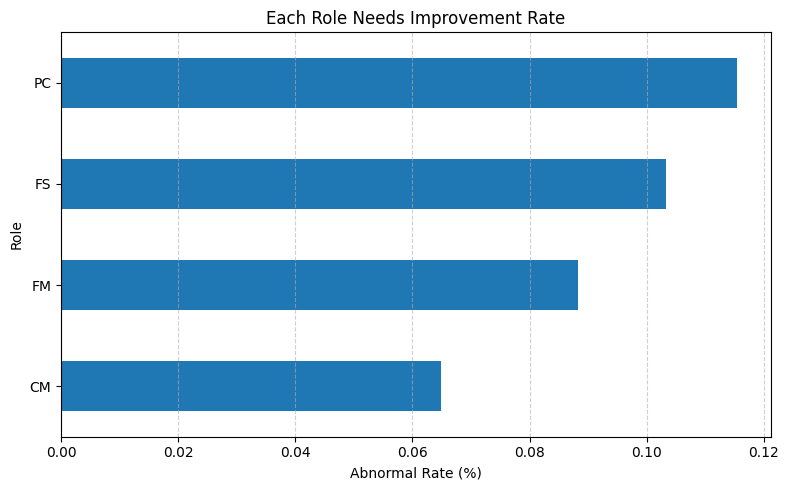

In [27]:
role_summary = performance.groupby('Role')['Needs_Improvement'].mean().sort_values()

plt.figure(figsize=(8, 5))
role_summary.plot(kind='barh')
plt.xlabel('Abnormal Rate (%)')
plt.title('Each Role Needs Improvement Rate')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

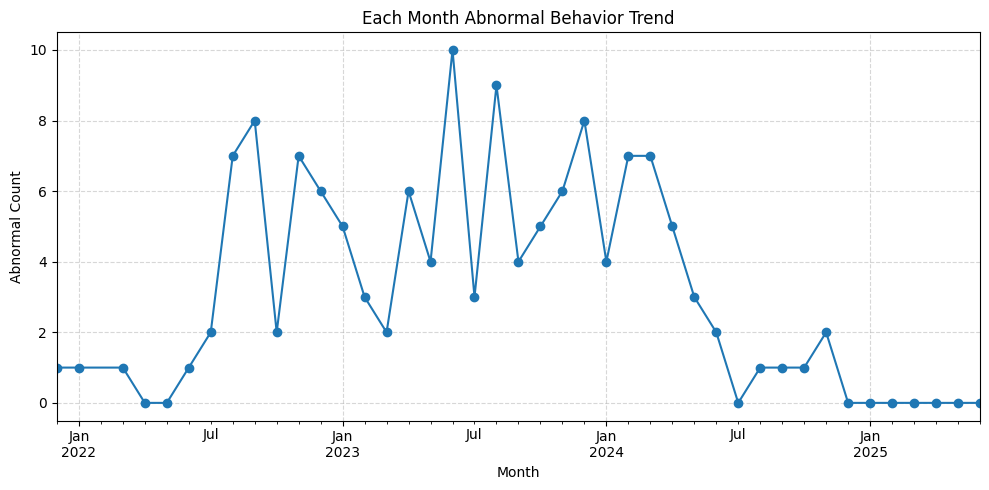

In [28]:
monthly_trend = performance.groupby('Month')['Needs_Improvement'].sum()

plt.figure(figsize=(10, 5))
monthly_trend.plot(marker='o')
plt.ylabel('Abnormal Count')
plt.title('Each Month Abnormal Behavior Trend')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# === Step 7.1: detect continuous abnormal for more than 2 months ===
performance['Needs_Improvement'] = performance['Needs_Improvement'].astype(int)

# rank based on people and month
performance = performance.sort_values(by=['Person', 'Role', 'Month'])

# consecutive bad performance
performance['Consecutive_Bad'] = (
    performance.groupby(['Person', 'Role'])['Needs_Improvement']
    .rolling(window=2).sum().reset_index(level=[0,1], drop=True) >= 2
)

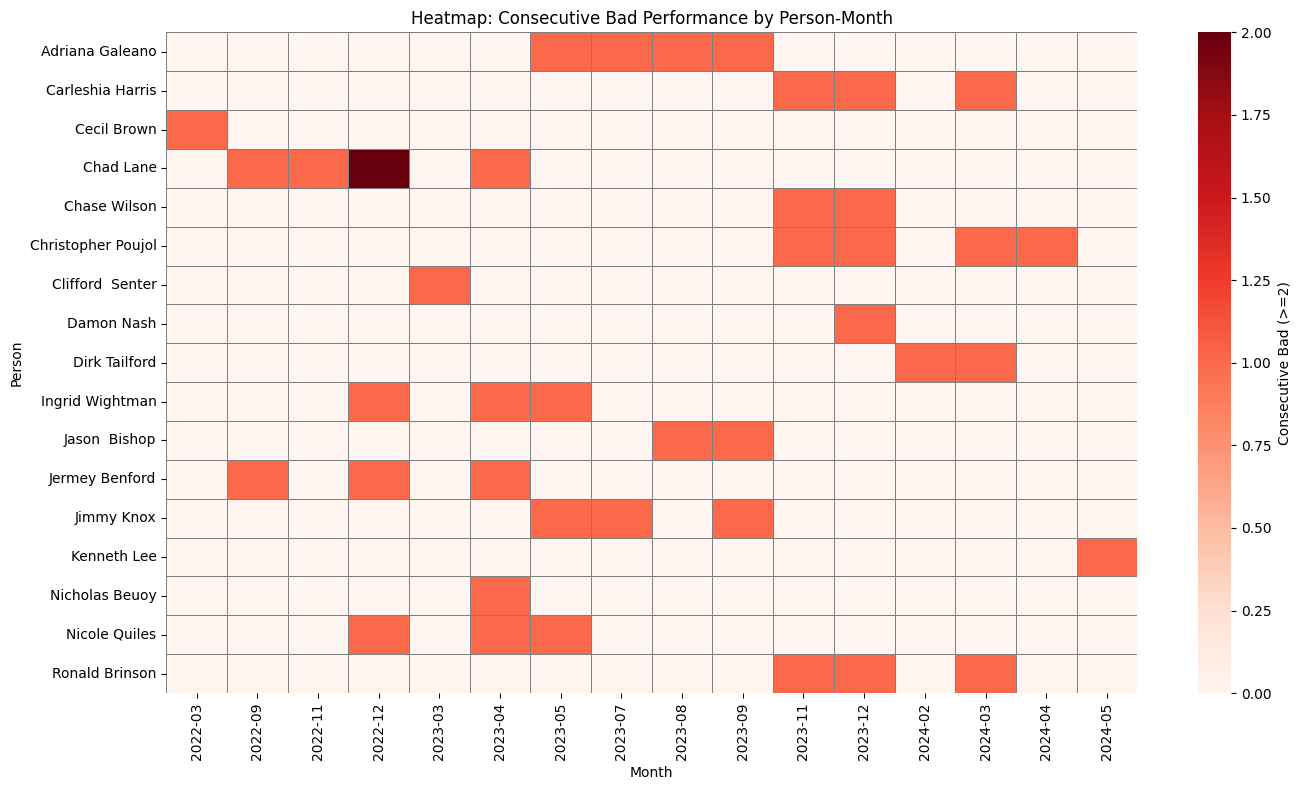

In [ ]:
# pivot table to create a person-month-role grid
heatmap_data = (
    performance[performance['Consecutive_Bad']]
    .pivot_table(index='Person', columns='Month', values='Consecutive_Bad', aggfunc='sum', fill_value=0)
)

# plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='Reds', linewidths=0.5, linecolor='grey', cbar_kws={'label': 'Consecutive Bad (>=2)'})
plt.title('Heatmap: Consecutive Bad Performance by Person-Month')
plt.ylabel('Person')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

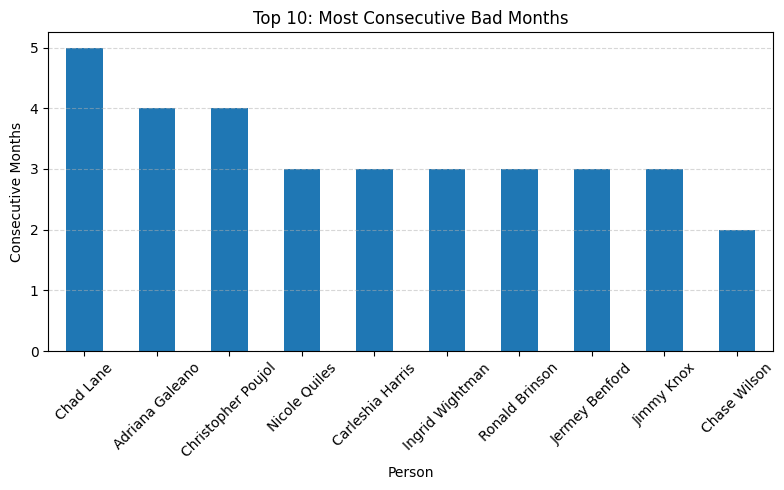

In [35]:
consec_count = performance.groupby('Person')['Consecutive_Bad'].sum().sort_values(ascending=False).head(10)

consec_count.plot(kind='bar', figsize=(8, 5), title='Top 10: Most Consecutive Bad Months', ylabel='Consecutive Months')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

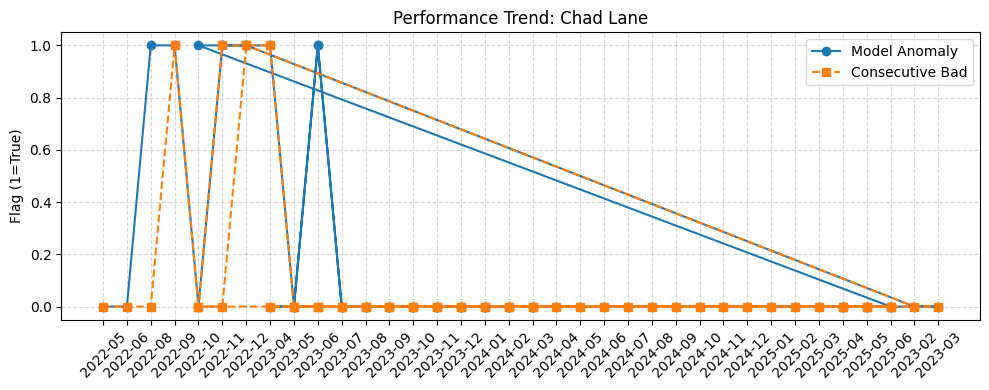

In [36]:
target_person = 'Chad Lane'  # replace with the person you want to analyze

df_person = performance[performance['Person'] == target_person]

plt.figure(figsize=(10, 4))
plt.plot(df_person['Month'].astype(str), df_person['Needs_Improvement'], marker='o', label='Model Anomaly')
plt.plot(df_person['Month'].astype(str), df_person['Consecutive_Bad'], marker='s', linestyle='--', label='Consecutive Bad')
plt.title(f'Performance Trend: {target_person}')
plt.ylabel('Flag (1=True)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Normalization --> Weighted Score --> Quantile Binning

In [42]:
# Normalize the features for scoring （we use MinMaxScaler to scale the features between 0 and 1）
scaler = MinMaxScaler()
performance[score_features] = scaler.fit_transform(performance[score_features])

# score calculation
performance['Behavior_Score'] = (
    0.15 * performance['Avg_Start_Delay'] +
    0.15 * performance['Avg_Completion_Delay'] +
    0.15 * performance['Avg_ACCC_to_Movein'] +
    0.10 * performance['Avg_MO_to_MR'] +
    0.15 * performance['Avg_PCD_to_ACSD'] +
    0.15 * performance['Avg_PCD_to_ACCC'] +
    0.10 * performance['Avg_Budget']
)

# performance level categorization
performance['Performance_Level'] = pd.qcut(performance['Behavior_Score'], q=4, labels=['excellent', 'good', 'average', 'need improvement'])

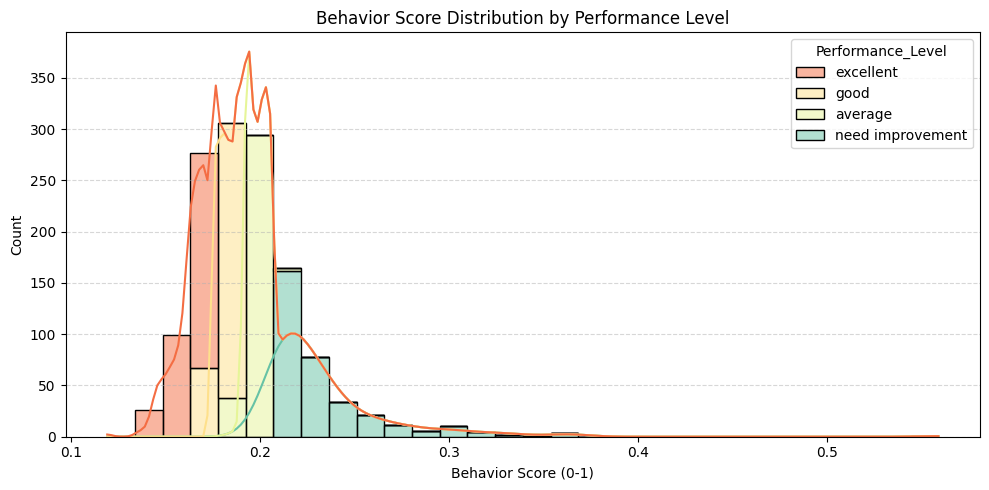

In [43]:
plt.figure(figsize=(10, 5))
sns.histplot(data=performance, x='Behavior_Score', hue='Performance_Level', bins=30, kde=True, palette='Spectral', multiple='stack')
plt.title('Behavior Score Distribution by Performance Level')
plt.xlabel('Behavior Score (0-1)')
plt.ylabel('Count')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

C:\Users\Yijia Wang\AppData\Local\Temp\ipykernel_26540\1011900897.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance.groupby(['Month', 'Performance_Level'])


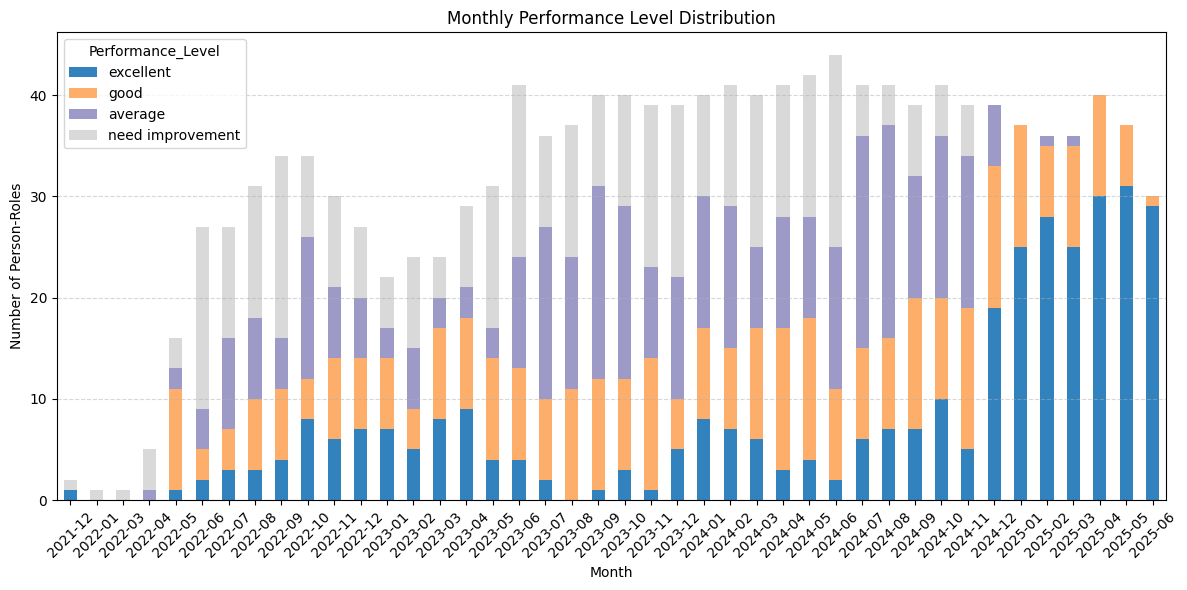

In [44]:
monthly_levels = (
    performance.groupby(['Month', 'Performance_Level'])
    .size()
    .unstack(fill_value=0)
)

monthly_levels.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20c')
plt.title('Monthly Performance Level Distribution')
plt.ylabel('Number of Person-Roles')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

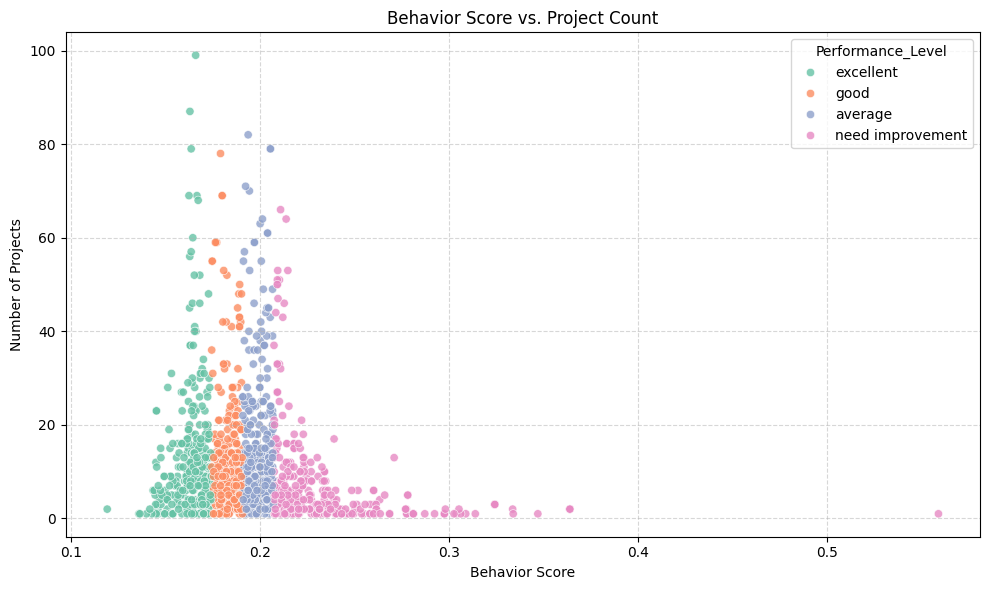

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=performance, x='Behavior_Score', y='Project_Count', hue='Performance_Level', palette='Set2', alpha=0.8)
plt.title('Behavior Score vs. Project Count')
plt.xlabel('Behavior Score')
plt.ylabel('Number of Projects')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

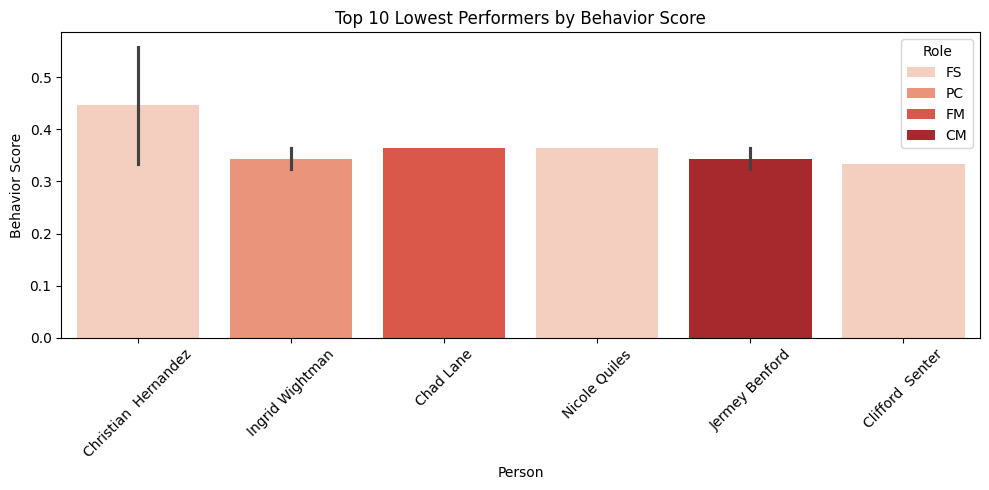

In [46]:
top_bad = performance.sort_values(by='Behavior_Score', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_bad, x='Person', y='Behavior_Score', hue='Role', dodge=False, palette='Reds')
plt.title('Top 10 Lowest Performers by Behavior Score')
plt.xticks(rotation=45)
plt.ylabel('Behavior Score')
plt.tight_layout()
plt.show()


### Every month top and last

In [15]:
# Top 3 every month
top = (
    performance
    .sort_values(['Month', 'Behavior_Score'])
    .groupby(['Month', 'Role'])
    .head(3)
    .assign(Rank='Top Performer')
)

# Bottom 3 every month
bottom = (
    performance
    .sort_values(['Month', 'Behavior_Score'], ascending=False)
    .groupby(['Month', 'Role'])
    .head(3)
    .assign(Rank='Bottom Performer')
)

rank_summary = pd.concat([top, bottom])
rank_summary

,Month,Role,Person,Project_Count,Avg_Start_Delay,Avg_Completion_Delay,Avg_ACCC_to_Movein,Missing_Uploads,Missing_Approvals,Avg_Budget,Anomaly_Score,Needs_Improvement,Consecutive_Bad,Behavior_Score,Performance_Level,Rank
0,2018-09,FS,Angel Cervantes,2,0.790499,0.100932,NaN,0.040816,0.071429,0.000000,1,0,False,NaN,NaN,Top Performer
1,2018-10,FS,Angel Cervantes,6,0.790499,0.108437,NaN,0.122449,0.214286,0.000000,-1,1,False,NaN,NaN,Top Performer
2,2018-11,FS,Angel Cervantes,9,0.790499,0.108474,NaN,0.183673,0.321429,0.000000,-1,1,True,NaN,NaN,Top Performer
3,2018-12,FS,Angel Cervantes,8,0.790499,0.101708,NaN,0.163265,0.285714,0.016698,-1,1,True,NaN,NaN,Top Performer
4,2018-12,FS,Clairece Brown Angel Cervantes,1,0.790499,0.100932,NaN,0.020408,0.035714,0.001914,1,0,False,NaN,NaN,Top Performer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,2018-12,FS,Angel Cervantes,8,0.790499,0.101708,NaN,0.163265,0.285714,0.016698,-1,1,True,NaN,NaN,Bottom Performer
4,2018-12,FS,Clairece Brown Angel Cervantes,1,0.790499,0.100932,NaN,0.020408,0.035714,0.001914,1,0,False,NaN,NaN,Bottom Performer
2,2018-11,FS,Angel Cervantes,9,0.790499,0.108474,NaN,0.183673,0.321429,0.000000,-1,1,True,NaN,NaN,Bottom Performer
1,2018-10,FS,Angel Cervantes,6,0.790499,0.108437,NaN,0.122449,0.214286,0.000000,-1,1,False,NaN,NaN,Bottom Performer


In [16]:
fs_only = performance[performance['Role'] == 'FS']

In [ ]:
# with pd.ExcelWriter('KPI Models.xlsx') as writer:
#     performance.to_excel(writer, sheet_name='KPI details', index=False)
#     rank_summary.to_excel(writer, sheet_name='Top and Bottom Performers', index=False)
#     performance[performance['Consecutive_Bad']].to_excel(writer, sheet_name='Consecutive Bad', index=False)
#     fs_only.to_excel(writer, sheet_name='FS', index=False)